In [227]:
import torch

torch.cuda.empty_cache()
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev


device(type='cuda')

In [228]:
from torchvision import transforms, datasets

INPUT_SIZE = 128

transform = transforms.Compose([
    transforms.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.5, 1.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(INPUT_SIZE),
    transforms.Normalize(mean=[0.485], std=[0.229]),
])

test_transform = transforms.Compose([
    transforms.CenterCrop(INPUT_SIZE),
    transforms.Normalize(mean=[0.485], std=[0.229]),
])


112


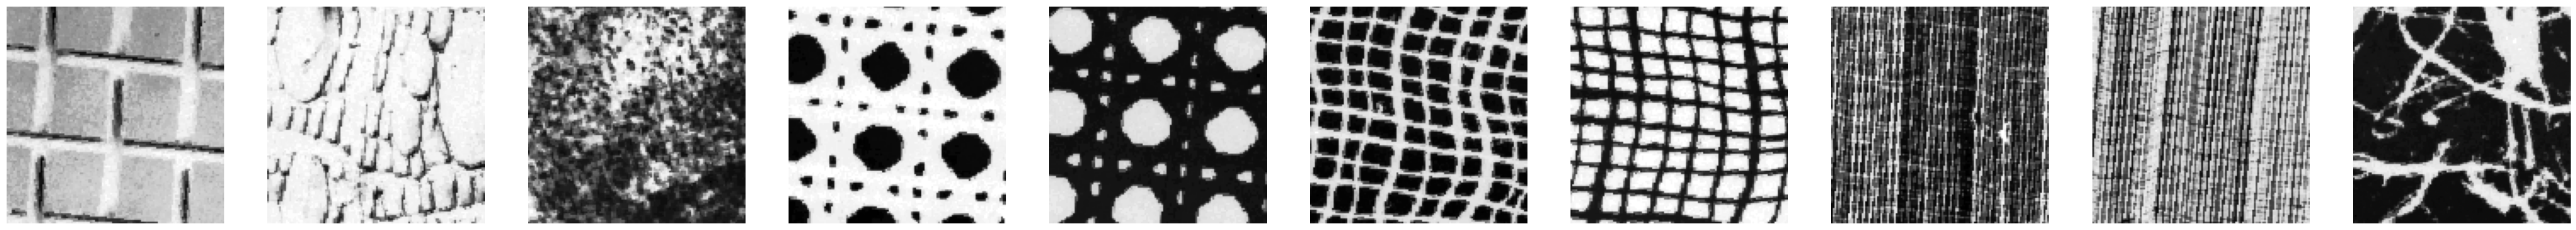

In [229]:
from datasets import Dataset as Brodatz
from vizutils import *
BATCH_SIZE = 16

class Data(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, index):
        im = self.data[index]
        im = torch.tensor(im).unsqueeze(0).float() / 255
        im = im.to(dev)
        return transform(im)
    def __len__(self):
        return len(self.data)

data = Brodatz("datasets/Original Brodatz")
print(len(data.images))
imgs = data.ToNumpy()
dataset = Data(imgs[:])

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


ImShowArray(dataset[:10].cpu().numpy()[0])

In [230]:
import torch.nn as nn
import torch.nn.functional as F
LATENT_SIZE = 64
s = 32
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # encode
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)  
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 4, 3, padding=1) 
        self.batch_norm3 = nn.BatchNorm2d(4)

        self.dense1 = nn.Linear(4*s*s, LATENT_SIZE)
        self.dense2 = nn.Linear(LATENT_SIZE, 4*s*s)

    

        # decode
        self.t_upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.t_conv1 = nn.Conv2d(4, 32, 3, padding=1)
        self.t_batch_norm4 = nn.BatchNorm2d(32)
        self.t_conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.t_batch_norm5 = nn.BatchNorm2d(32)
        self.t_conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.t_batch_norm6 = nn.BatchNorm2d(32)
        self.t_conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.t_convf = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        # encode 
        x = F.relu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.batch_norm2(x)
        x = self.pool(x)  # compressed representation
        x = F.relu(self.conv3(x))
        x = self.batch_norm3(x)
        
        x = x.view(-1, 4*s*s)
        x = F.relu(self.dense1(x))
        # latent
        self.latent = x

        x = F.relu(self.dense2(x))
        x = x.view(-1, 4, s, s)
        # decode
        x = F.relu(self.t_conv1(x))
        x = self.t_batch_norm4(x)
        x = self.t_upsample(x)
        x = F.relu(self.t_conv2(x))
        x = self.t_batch_norm5(x)
        x = self.t_upsample(x)
        x = F.relu(self.t_conv3(x))
        x = self.t_batch_norm6(x)

        x = F.relu(self.t_conv4(x))
        x = self.t_convf(x)
                
        return x

# initialize the NN
model = ConvAutoencoder()
model.to(dev)
print(model)
print(model(torch.randn(1,1,INPUT_SIZE,INPUT_SIZE).to(dev)).shape)
print(model.latent.shape)




ConvAutoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=4096, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=4096, bias=True)
  (t_upsample): Upsample(scale_factor=2.0, mode='nearest')
  (t_conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_batch_norm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv2): 

In [231]:
import matplotlib.pyplot as plt
loss = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)

class CrossCorr(nn.Module):
    def __init__(self):
        super(CrossCorr, self).__init__()
    
    def Autocorr(self,img):
       # img =img- img.mean()
        pad = transforms.Pad(img.shape[2]//2)
        img_padded = pad(img)
        convolved = F.conv2d(img_padded.unsqueeze(1),img.unsqueeze(1))
        return convolved / convolved.max()
    
    def PlotAutocorrs(self,inputs,targets):
        fig, axs = plt.subplots(2, len(inputs), figsize=(15, 5))
       
        axs[0].imshow(self.Autocorr(inputs[0])[0].squeeze(0).cpu().detach().numpy())
        axs[1].imshow(self.Autocorr(targets[0])[0].squeeze(0).cpu().detach().numpy())
        plt.show()
    def forward(self, inputs, targets):
        sm = 0
        pad = transforms.Pad(inputs.shape[2]//2)
        for i in range(len(inputs)):
            auto_input = self.Autocorr(inputs[i])
            auto_target = self.Autocorr(targets[i])
            sm += loss(auto_input, auto_target)
        return sm


filters = dataset[3].unsqueeze(0)
inputs = dataset[3].unsqueeze(0)
c_loss = CrossCorr()
c_loss(inputs, filters)





tensor(0.0174, device='cuda:0')

In [232]:
from tqdm.notebook import tqdm

epochs = 250
mean_errors = []
model.eval()
for epoch in tqdm(range(epochs)):
    errors = []
    for data in dataloader:
        data = data.to(dev)
        opt.zero_grad()
        output = model(data)
        l = c_loss(output, data)

        l.backward()
        opt.step()
        errors.append(l.item())
    mean_errors.append(sum(errors)/len(errors))
    if epoch % (epochs/10) == 0:
        print(f"epoch: {epoch}, loss: {mean_errors[-1]}")

  0%|          | 0/250 [00:00<?, ?it/s]

epoch: 0, loss: 2.483266370637076


KeyboardInterrupt: 

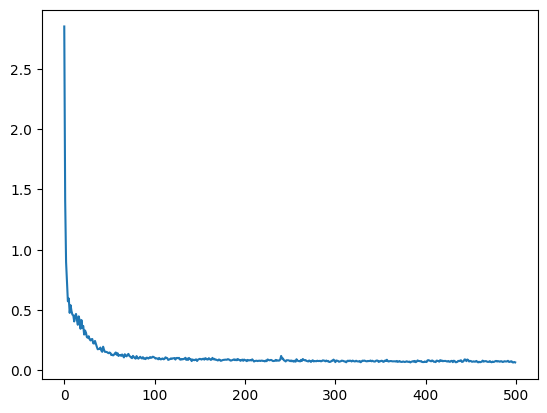

In [ ]:
import matplotlib.pyplot as plt
plt.plot(mean_errors)
plt.show()

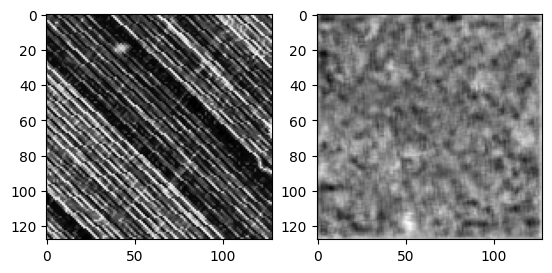

torch.Size([1, 64])


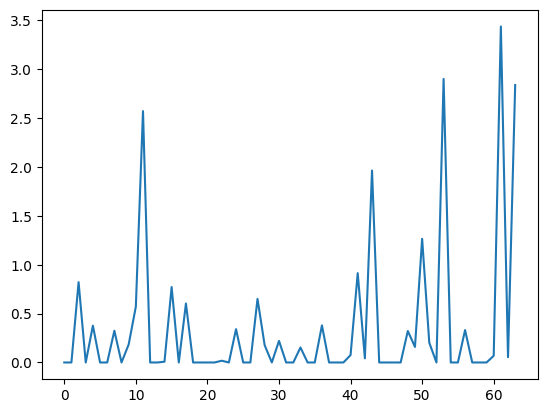

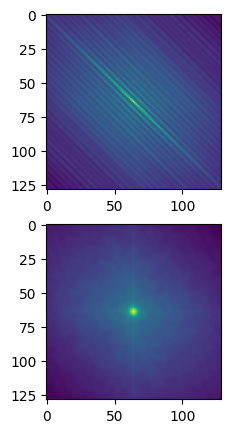

In [ ]:
import numpy as np
sample = dataset[7]
test_sample = sample.unsqueeze(0)

result = model(test_sample).to("cpu").detach().numpy().squeeze()

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(sample.to("cpu").detach().numpy().squeeze(), cmap="gray")
ax2.imshow(result, cmap="gray")
plt.show()

print(model.latent.shape)
# plot latent space
latent = model.latent.to("cpu").detach().numpy()
latent = np.squeeze(latent)
plt.plot(latent)
plt.show()

c_loss.PlotAutocorrs(test_sample, model(test_sample))

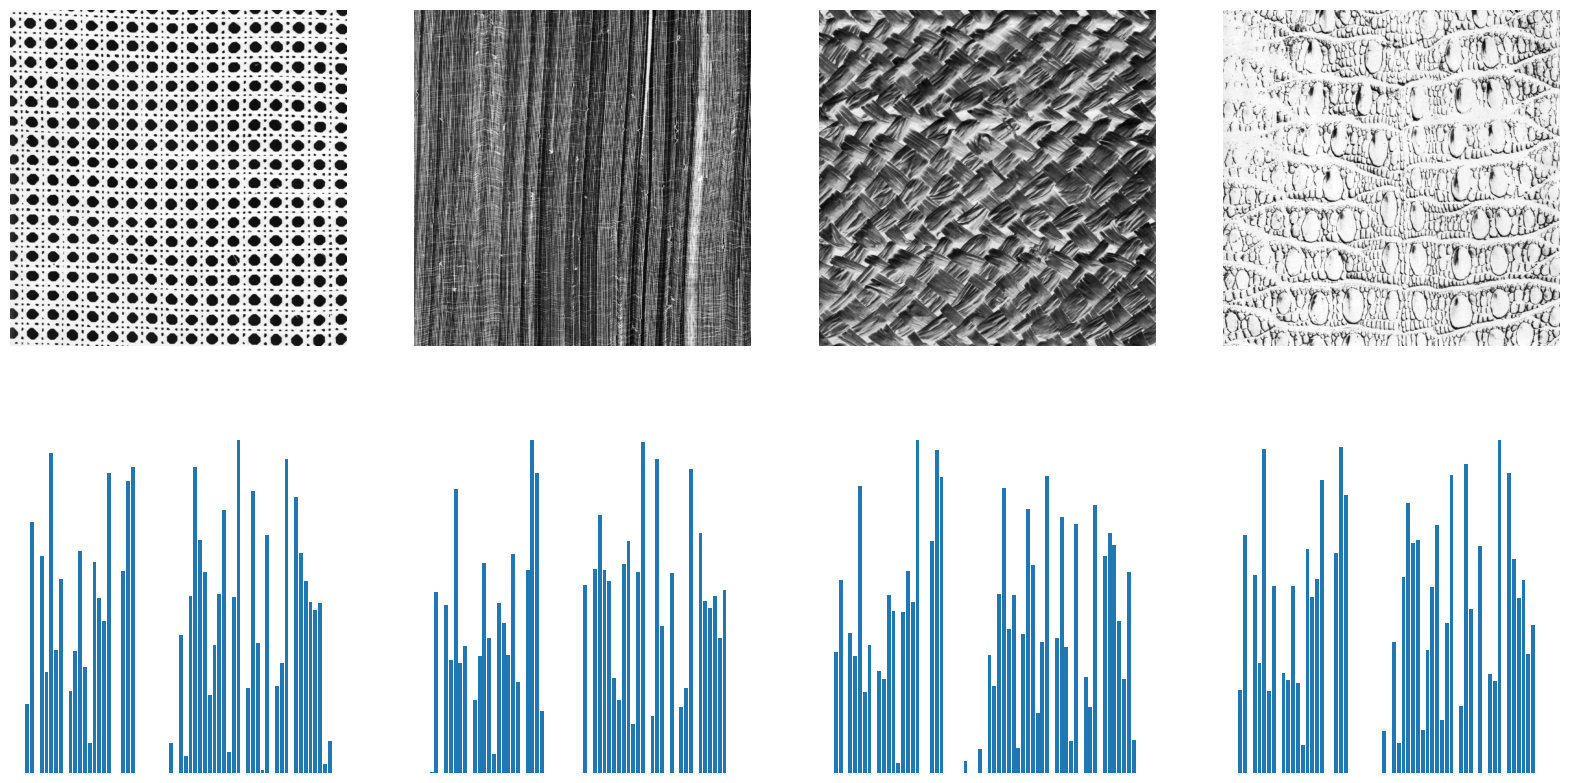

In [ ]:
from vizutils import *
from computils import *

def Aebased(img):
    img = torch.tensor(img).unsqueeze(0).float() / 255
    img = img.to(dev)
    img = test_transform(img)
    model(img.unsqueeze(0))
    return model.latent.to("cpu").detach().numpy().squeeze()

test_imgs = [imgs[3],imgs[7],imgs[22],imgs[1]]

res = Calc(test_imgs,Aebased)
ImShowArrayWithHistograms(test_imgs,res)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


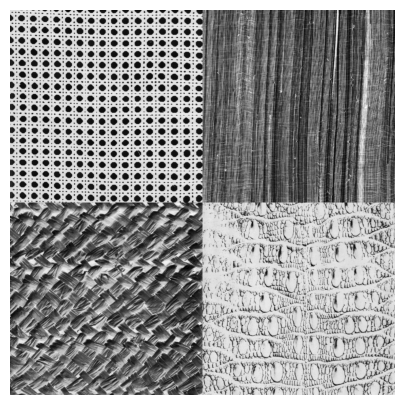

  0%|          | 0/98 [00:00<?, ?it/s]

[[3. 3. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [3. 0. 3. ... 1. 1. 1.]
 ...
 [2. 2. 2. ... 3. 3. 3.]
 [2. 2. 2. ... 3. 3. 0.]
 [2. 2. 2. ... 3. 3. 0.]]


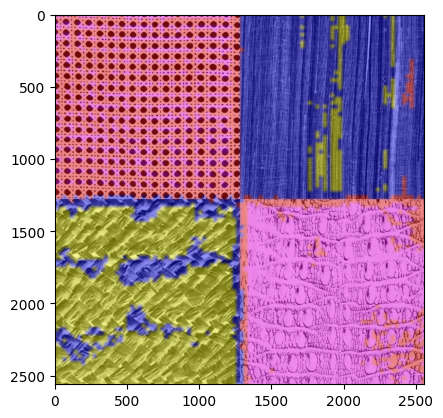

In [ ]:
%load_ext autoreload
%autoreload 2
from computils import *
SegmentationExampleVectorDescriptor(test_imgs, Aebased,imgs[0].shape[0]*2,True,random_patches=True, window_size=INPUT_SIZE,step_size=25)